In [1]:
import uproot as uproot

import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler

from torchvision.models import resnet18

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from IPython.display import clear_output

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/ecal-experiment-4')

In [2]:
# %tensorboard --logdir=runs

In [10]:
# root_file = uproot.open('data/0001_64k_real_spectra_15x15_spot.root')
root_file = uproot.open('data/0001_64k_wpc_10x10_spot.root')
nevents=None

# Наблюдаемые величины
RawE = root_file['ecalNT']['RawEnergyDeposit'].arrays(library='np')['RawEnergyDeposit'][:nevents]
x = root_file['ecalNT']['RawX'].arrays(library='np')['RawX'][:nevents]
y = root_file['ecalNT']['RawY'].arrays(library='np')['RawY'][:nevents]
z = root_file['ecalNT']['RawZ'].arrays(library='np')['RawZ'][:nevents]
# EnergyDeposit = [img.reshape(15,15)[None,:,:] for img in np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])]

EnergyDeposit = np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])
EnergyDeposit = EnergyDeposit.reshape(-1, 10, 10)[:, None, :, :]

# Величины на входе симулятора
ParticlePDG = np.array(root_file['ecalNT']['ParticlePDG'].array())[:nevents]
ParticleMomentum_v = np.array(root_file['ecalNT']['ParticleMomentum'].array())[:nevents]
ParticleMomentum = np.sum(ParticleMomentum_v * ParticleMomentum_v, axis=1) ** 0.5

In [15]:
ParticlePoint = np.array(root_file['ecalNT']['ParticlePoint'].array())[:nevents]

ParticlePoint[:,0].min(), ParticlePoint[:,0].max()

(-3.0298981103941647, 3.029907831248542)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [17]:
ParticlePoint[:, :2]

array([[-0.02483251, -2.34571997],
       [-1.07279692,  0.48191807],
       [-1.64748919,  2.98971535],
       ...,
       [ 1.41334892,  1.21153678],
       [-2.91586591, -2.58413133],
       [ 2.17813227,  1.69902604]])

In [35]:
np.concatenate((ParticleMomentum[:, None], ParticlePoint), axis=1).shape

(64000, 4)

In [36]:
X = np.array(EnergyDeposit)
y = np.concatenate((ParticleMomentum[:, None], ParticlePoint[:, :2]), axis=1)

# X = X[y < 10]
# y = y[y < 10]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_generator = torch.Generator()
train_generator.manual_seed(0)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=seed_worker, generator=train_generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

In [50]:
trg[:, 0].shape

torch.Size([64])

In [48]:
from utils import Loss3

loss = Loss3(reduction="none")

data, trg = next(iter(train_loader))

loss(trg[:, 1:3], trg[:, 1:3])

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

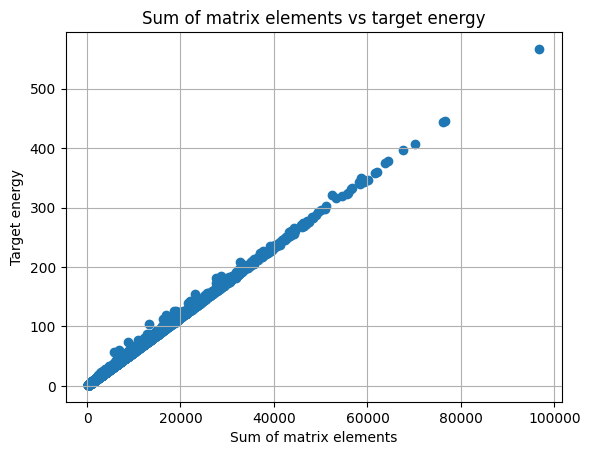

In [7]:
plt.scatter(X_train.sum(axis=(1, 2, 3)), y_train)
plt.grid()
plt.title("Sum of matrix elements vs target energy")
plt.xlabel("Sum of matrix elements")
plt.ylabel("Target energy")

plt.show()

In [8]:
# torch.autograd.set_detect_anomaly(True)

In [8]:
class SimpleModel(nn.Module):
    def __init__(self, height=15, width=15) -> None:
        super(SimpleModel, self).__init__()

        self.height = height
        self.width = width

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
        )

        self.fc1 = nn.Linear(3600, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.flatten()
        return x

In [9]:
class LinearModel(nn.Module):
    def __init__(self, height=15, width=15, output_positive=False, eps=1e-9) -> None:
        super(LinearModel, self).__init__()

        self.height = height
        self.width = width

        self.fc1 = nn.Linear(self.height * self.width, 1)
        self.output_positive = output_positive
        self.eps = eps
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.height * self.width)
        x = self.fc1(x)
        x = x.flatten()
        # print(f"Model: {torch.max(x)}")
        if self.output_positive:
            x = F.softplus(x)
        # print(f"Model: {torch.max(x)}")
        return x

In [31]:
class MyModel(nn.Module):
    def __init__(self, height=15, width=15, n_scales=7, hidden_dim=4, output_positive=True) -> None:
        super(MyModel, self).__init__()

        self.height = height
        self.width = width

        self.output_positive = output_positive

        self.n_scales = n_scales
        self.hidden_dim = hidden_dim
        self.scales = [0.5 ** i for i in range(self.n_scales)]

        self.models = []
        for scale in self.scales:
            self.models.append(self._get_model())

        self.models = nn.ModuleList(self.models)
        
        self.fc_last = nn.Linear(self.n_scales * self.hidden_dim, 1)
    
    def _get_model(self):
        layer = nn.Sequential(
            nn.Linear(self.height * self.width, self.hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
        )
        return layer

        # return nn.Linear(self.height * self.width, self.hidden_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.height * self.width)
        
        result = None
        for scale, model in zip(self.scales, self.models):
            current = model(x * scale) / scale
            if result is None:
                result = current
            else:
                result = torch.cat((result, current), dim=1)

        # result = self.fc_last(result)
        result = result.mean(dim=1)

        if self.output_positive:
            result = F.softplus(result)
        return result

In [103]:
class MyResnet18(nn.Module):
    def __init__(self, height=15, width=15, remove_batch_norm=True, output_positive=True) -> None:
        super(MyResnet18, self).__init__()

        self.height = height
        self.width = width

        self.output_positive = output_positive

        self.model = resnet18(num_classes=1)
        self.model.conv1 = nn.Conv2d(1, 64, 1, bias=False)

        if remove_batch_norm:
            self._remove_batch_norms(self.model)

    def _remove_batch_norms(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.BatchNorm2d):
                identity_layer = nn.Identity()
                setattr(module, name, identity_layer)
            else:
                self._remove_batch_norms(child)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        
        result = self.model(x)

        if self.output_positive:
            result = F.softplus(result)
        return result

In [80]:
def train_fn(train_loader, val_loader, model, optimizer, lr_scheduler, criterion, num_epochs, device, log_freq=None, max_grad_norm=20):

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    train_loss = []
    train_batch_idx = []
    train_num_batches = 0

    val_loss = []
    
    pbar = tqdm(range(1, num_epochs + 1))

    for epoch in pbar:
        epoch_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        num_batches = 0
        model.train()
        for data, trg in train_loader:
            train_num_batches += 1
            num_batches += 1
            optimizer.zero_grad()

            data = data.to(device)
            trg = trg.to(device)

            output = model(data)
            loss = criterion(output, trg, 1 / trg)

            epoch_loss += loss.detach()

            loss.backward()

            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            # writer.add_scalar('Training loss', loss.item(), train_num_batches)
            # writer.add_scalar('Model gradient norm', grad_norm.item(), train_num_batches)
            # writer.add_scalar('Learning rate', get_lr(optimizer), train_num_batches)

            if log_freq is not None and train_num_batches % log_freq == 0:
                train_batch_idx.append(train_num_batches)
                train_loss.append((epoch_loss / num_batches).item())
                clear_output(True)

                plt.figure(figsize=(15, 7))

                plt.subplot(1, 2, 1)
                plt.plot(train_batch_idx, train_loss)
                plt.xlabel("Batch index")
                plt.ylabel("Loss")
                plt.grid()
                plt.title("Train loss")

                plt.subplot(1, 2, 2)
                plt.plot(list(range(1, epoch)), val_loss)
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.grid()
                plt.title("Validation loss")

                plt.show()
                print(f"Epoch: {epoch}/{num_epochs} || Batch: {num_batches}/{len(train_loader)} || Train loss: {epoch_loss.item() / num_batches:0.4f} || Val loss: {(val_loss[-1] if val_loss else -1.0):0.4f}")
        
        cur_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            for data, trg in val_loader:
                data = data.to(device)
                trg = trg.to(device)

                output = model(data)
                cur_loss += criterion(output, trg, 1 / trg).detach()
        
        cur_loss /= len(val_loader)

        val_loss.append(cur_loss.item())
        # writer.add_scalar('Validation loss', cur_loss.item(), epoch)

        if lr_scheduler is not None:
            lr_scheduler.step()
    
    return train_loss, train_batch_idx

In [81]:
def loss_fn_1(pred, trg, weights, eps=1e-9, reduction='mean'):
    loss = torch.sqrt(F.mse_loss(pred, trg, reduction='none') + eps) * weights
    if reduction == 'mean':
        loss = loss.mean()
    return loss

def loss_fn_2(pred, trg, weights, eps=1e-9, reduction='mean'):
    loss = ((pred - trg) * weights) ** 2
    if reduction == 'mean':
        loss = loss.mean()
    loss = torch.sqrt(loss)
    return loss

def loss_fn_3(pred, trg, weights):
    return F.mse_loss(pred, trg)

def loss_fn_4(pred, trg, weights, eps=1e-9):
    return torch.sqrt(F.mse_loss(torch.log(pred + 1), torch.log(trg + 1)))

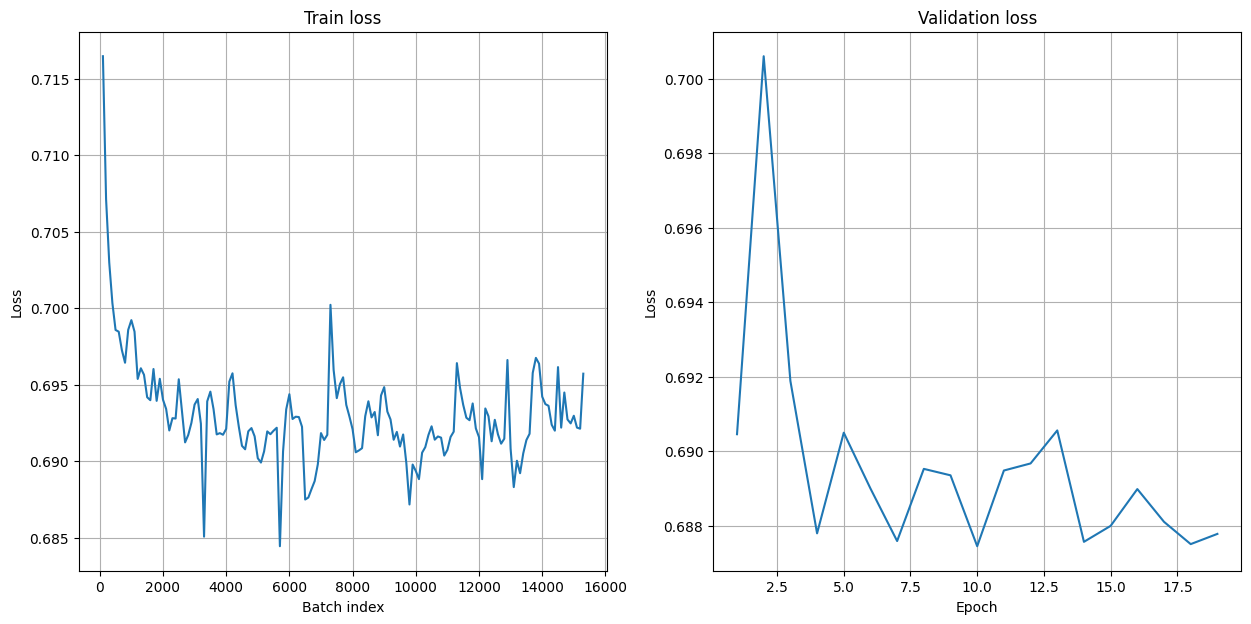

Epoch: 20/100 || Batch: 81/801 || Train loss: 0.6957 || Val loss: 0.6878


KeyboardInterrupt: 

In [105]:
# model = MyModel(
#     height=train_dataset[0][0].shape[-2],
#     width=train_dataset[0][0].shape[-1],
#     n_scales=10,
#     hidden_dim=64,
#     output_positive=True,
# ).to(device)

# model = LinearModel(
#     height=train_dataset[0][0].shape[-2],
#     width=train_dataset[0][0].shape[-1],
#     output_positive=True,
# ).to(device)

# model = MyResnet18(
#     height=train_dataset[0][0].shape[-2],
#     width=train_dataset[0][0].shape[-1],
#     remove_batch_norm=False,
#     output_positive=False,
# ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.8)
criterion = loss_fn_2
num_epochs = 100

train_loss, train_batch_idx = train_fn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    log_freq=100,
    max_grad_norm=20,
)

In [108]:
def collect_losses(model, val_loader, loss_fn, device):
    trg_vals, loss_vals = [], []
    model.eval()
    all_outputs = torch.zeros((0,), device=device)
    all_targets = torch.zeros((0,), device=device)
    with torch.no_grad():
        for data, trg in val_loader:
            data = data.to(device)
            trg = trg.to(device)

            output = model(data)

            all_outputs = torch.cat((all_outputs, output), dim=0)
            all_targets = torch.cat((all_targets, trg), dim=0)

            loss = loss_fn(output, trg, 1 / trg, reduction='none').detach()
            trg_vals += trg.cpu().numpy().tolist()
            loss_vals += loss.cpu().numpy().tolist()
        
        total_loss = loss_fn(all_outputs, all_targets, 1 / all_targets).detach()
    return trg_vals, loss_vals, total_loss

val_trg, val_loss, total_loss = collect_losses(model, val_loader, loss_fn_2, device)

print(f"RMSE/E loss on validation: {total_loss:0.4f}")

RMSE/E loss on validation: 0.6910


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12802,) + inhomogeneous part.

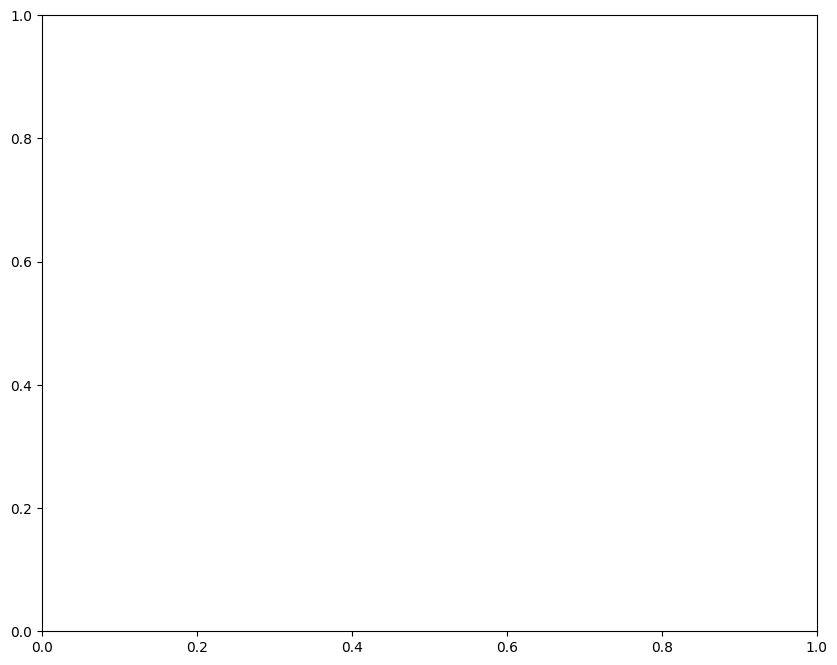

In [107]:
plt.figure(figsize=(10, 8))
plt.scatter(val_trg, val_loss, s=10)
plt.title('Loss on validation set')
plt.xlabel('Momentum')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()
plt.show()

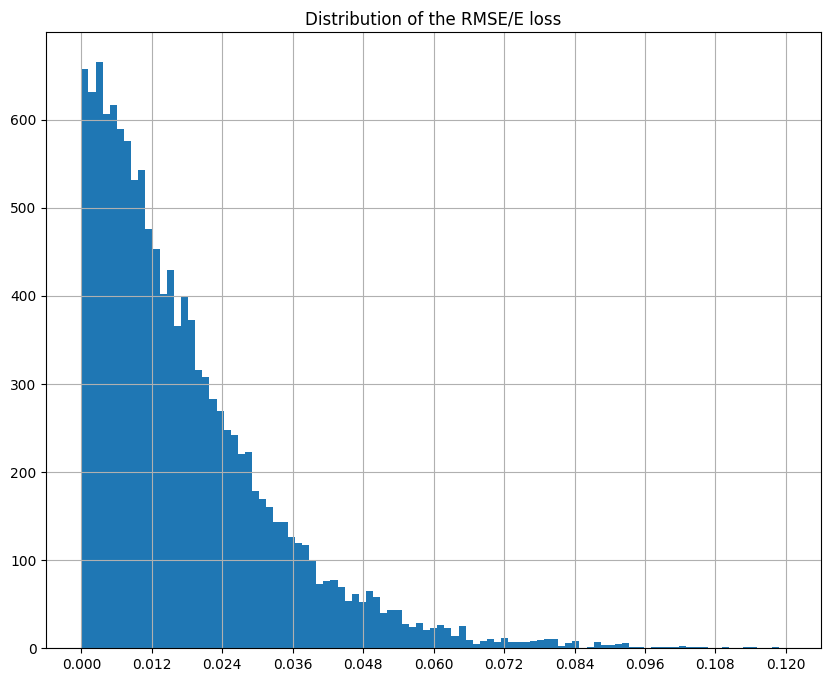

In [24]:
plt.figure(figsize=(10, 8))
plt.hist(val_loss, bins=np.linspace(0, 0.12, 100))
plt.xticks(np.linspace(0, 0.12, 11))
plt.grid()
plt.title("Distribution of the RMSE/E loss")

plt.show()

KeyboardInterrupt: 

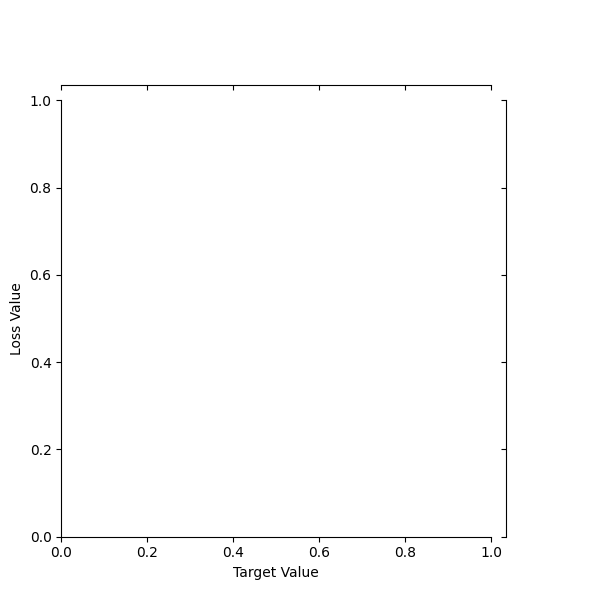

In [216]:
data = pd.DataFrame({'Target Value': val_trg, 'Loss Value': val_loss})

sns.jointplot(data=data, x='Target Value', y='Loss Value', kind='kde', fill=True)

sns.scatterplot(data=data, x='Target Value', y='Loss Value', color='r', alpha=0.1, size=1)

plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()

plt.show()

In [239]:
model.fc1.bias

Parameter containing:
tensor([-0.0552], device='cuda:0', requires_grad=True)

In [44]:
model.models[0][0].weight.shape

torch.Size([64, 225])

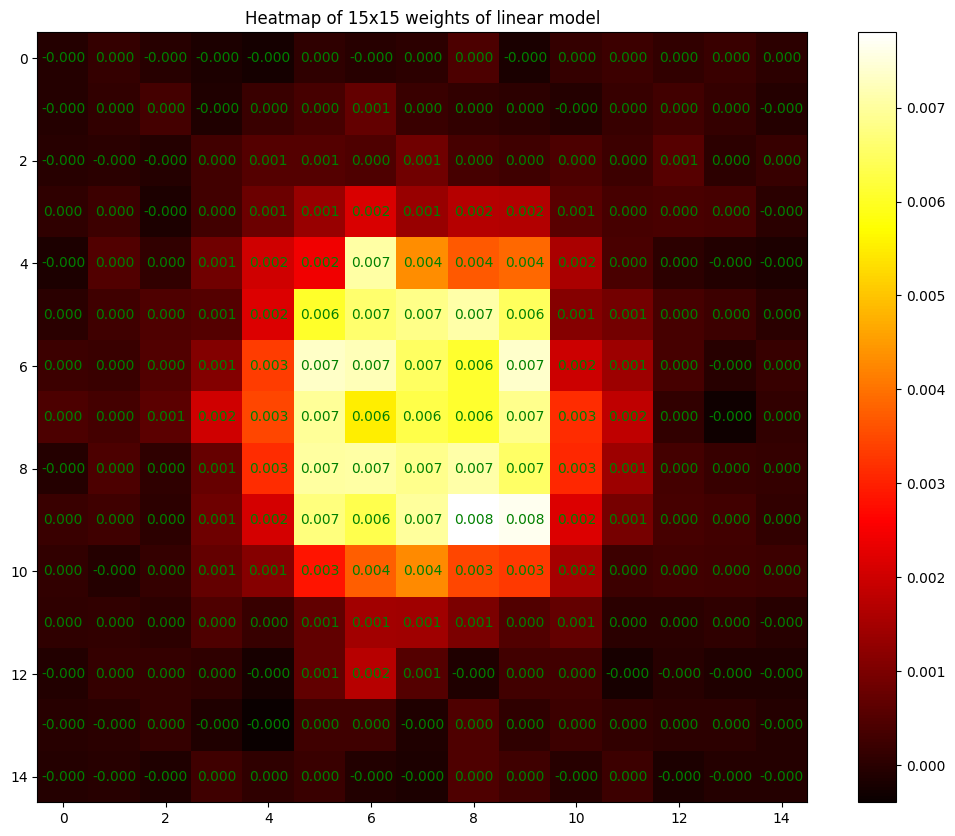

In [59]:
linear_weights = model.models[4][0].weight.mean(dim=0).data.flatten().cpu().reshape(15, 15)

plt.figure(figsize=(13, 10))
plt.imshow(linear_weights, cmap='hot', interpolation='nearest')
for i in range(linear_weights.shape[0]):
    for j in range(linear_weights.shape[1]):
        text = plt.text(j, i, f"{linear_weights[i, j]:.3f}",
                        ha="center", va="center", color="green")

plt.title("Heatmap of 15x15 weights of linear model")
plt.colorbar()
plt.show()

In [44]:
def train_n_models(model_type, num_models, num_epochs, device, loss_fn):
    models = []
    for _ in range(num_models):
        model = model_type().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

        train_loss, train_batch_idx = train_fn(
            train_loader=train_loader,
            val_loader=val_loader,
            model=model,
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
            criterion=loss_fn,
            num_epochs=num_epochs,
            device=device,
            log_freq=None,
            max_grad_norm=20,
        )

        models.append(model)

    return models

linear_models = train_n_models(
    LinearModel,
    20,
    20,
    device,
    loss_fn
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

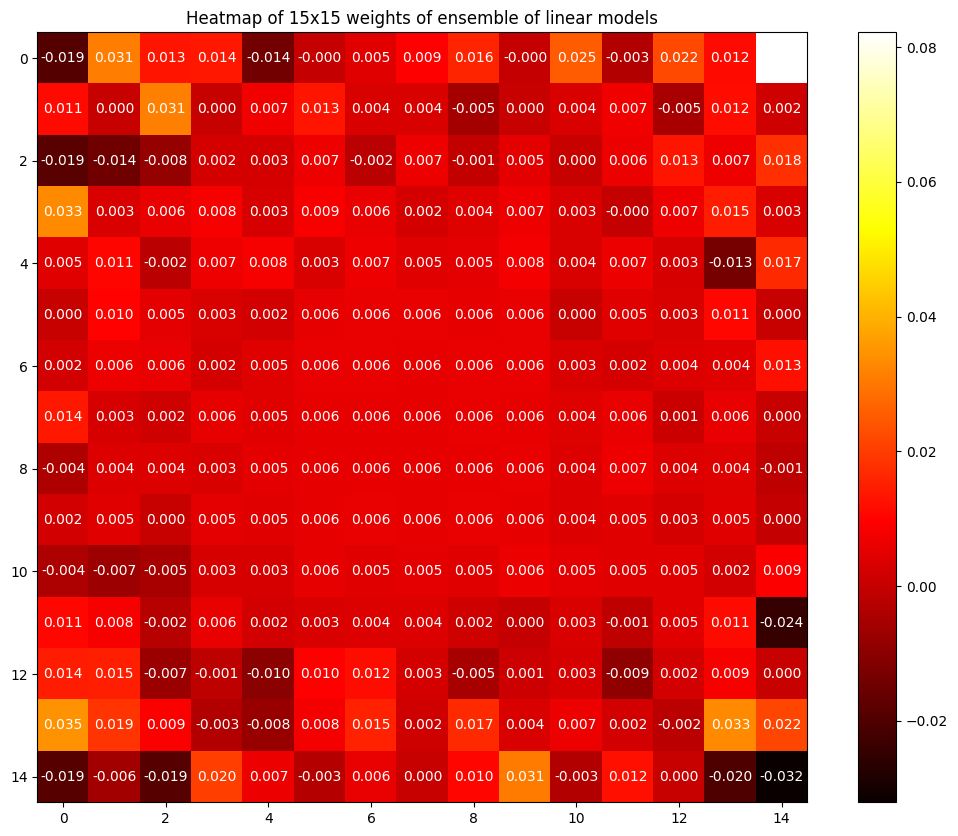

In [74]:
linear_ensemble_weights = torch.zeros((15, 15))

for model in linear_models:
    linear_ensemble_weights += model.fc1.weight.data.flatten().cpu().reshape(15, 15)

linear_ensemble_weights /= len(linear_models)

plt.figure(figsize=(13, 10))
plt.imshow(linear_ensemble_weights, cmap='hot', interpolation='nearest')
for i in range(linear_ensemble_weights.shape[0]):
    for j in range(linear_ensemble_weights.shape[1]):
        text = plt.text(j, i, f"{linear_ensemble_weights[i, j]:.3f}",
                        ha="center", va="center", color="w")

plt.title("Heatmap of 15x15 weights of ensemble of linear models")
plt.colorbar()
plt.show()

In [60]:
class VotingModel(nn.Module):
    def __init__(self, models, height=15, width=15) -> None:
        super(VotingModel, self).__init__()

        self.height = height
        self.width = width
        
        self.models = models
    
    def forward(self, x):
        batch_size = x.shape[0]
        result = torch.zeros(batch_size).to(x.device)
        for model in self.models:
            result += model(x)
        result /= len(self.models)
        return result

In [61]:
ensemble = VotingModel(linear_models).to(device)

In [73]:
_, losses = collect_losses(ensemble, val_loader)

np.mean(losses)

0.0169282457741418